In [29]:
import numpy as np
import matplotlib.pyplot as plt

In [30]:
def initialize_membership_matrix(num_samples, num_clusters):
    membership_mat = np.random.rand(num_clusters, num_samples)
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

def initial_centroids(num_clusters, num_features):
    return np.random.rand(num_clusters, num_features)
    

In [31]:
def epsilon_insensitive_loss(y_true, y_pred, epsilon):
    # Calculate absolute errors
    errors = np.abs(y_true - y_pred)
    # Apply epsilon-insensitive penalty
    loss = np.maximum(0, errors - epsilon)
    return np.mean(loss)

In [32]:
def update_membership_matrix(data, centroids, num_clusters, epsilon, m):
    # Update the membership matrix
    num_samples = data.shape[0]
    membership_mat = np.zeros((num_clusters, num_samples)).astype('float128')
    for i in range(num_samples):
        denominator = np.sum(epsilon_insensitive_loss(data[i], centroids, epsilon)**(1/(m-1))) 
        for k in range(num_clusters):
            membership_mat[k, i] = (epsilon_insensitive_loss(data[i], centroids[k], epsilon) ** (1/(1-m))) / (denominator + 1e-8)
            if np.isinf(membership_mat[k, i]):
                membership_mat[k, i] = 1
    membership_mat /= np.sum(membership_mat, axis=0)
    return membership_mat

In [33]:
from scipy.optimize import minimize


EPSILON = .01
DATA = None
L    = None


def objective(x):
    global EPSILON 
    global DATA
    global L
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    temp = 0
    for k in range(len(a)):
        temp += (a[k] - b[k])*DATA[k,L]
    return temp + sum(a + b) * EPSILON

def constraint(x):
    a = x[:len(x)//2]
    b = x[len(x)//2:]
    return sum(a) - sum(b)

def Lambda(num_samples, membership_mat, i_index, m):
    initial_guess = [0.] * num_samples*2
    bounds_a = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds_b = [(0, membership_mat[i_index, j]**m) for j in range(num_samples)]
    bounds = np.concatenate((bounds_a, bounds_b))
    constraint_eq = {'type': 'eq', 'fun': constraint}
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraint_eq)

    return result.x[:len(result.x)//2], result.x[len(result.x)//2:]

def update_centroid(data, num_samples, num_features, num_clusters, centroids, epsilon, membership_mat, m):
    global EPSILON, DATA, L
    EPSILON = epsilon
    DATA = data
    for i in range(num_clusters):
        for j in range(num_features):
            L = j
            l1, l2 = Lambda(num_samples, membership_mat, i, m)
            f, s = 0., 0.
            for ns in range(num_samples):
                if 0<l1[ns]<membership_mat[i, ns]:
                    f += data[ns][j] + epsilon
                if 0<l2[ns]<membership_mat[i, ns]:
                    s += data[ns][j] - epsilon
            # print(f, end=":")
            # print(s)
            centroids[i][j] = (f+s) / np.unique(np.concatenate((l1, l2))).shape[0]
    
    return centroids
        

In [34]:
def fuzzy_cmeans(data, num_clusters, max_iter, epsilon, m):
    num_samples, num_features = data.shape
    cen_mat = initial_centroids(num_clusters, num_features)
    for _ in range(max_iter):
        print(_, end=',')
        mem_mat = update_membership_matrix(data, cen_mat, num_clusters, epsilon, m)
        cen_mat = update_centroid(data, num_samples, num_features, num_clusters, cen_mat, epsilon, mem_mat, m)
        
    print(cen_mat)
    print(mem_mat)
    return cen_mat, mem_mat
        

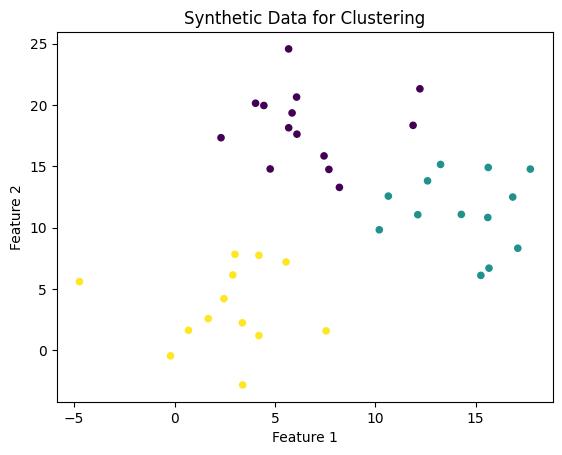

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,

/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/media/mrj/documents/AI/MachineLearning/.venv/lib/python3.10/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


17,18,19,[[ 7.14364713 10.64798875]
 [ 7.66871474 10.80657777]
 [ 7.73749229 10.72026746]]
[[1.59967091e-01 6.00019874e-13 4.29672084e-06 6.32389525e-01
  1.58731253e-03 1.34231524e-05 3.77832322e-22 1.64346852e-01
  1.46986914e-07 2.55835898e-02 7.58476497e-01 6.84428321e-02
  5.29243676e-01 5.14370840e-01 1.62205235e-01 7.91944386e-01
  4.96001782e-01 9.94376802e-02 3.27843699e-05 1.41905160e-01
  7.16852312e-01 5.44650756e-01 1.74198298e-10 4.61940353e-01
  6.64283572e-01 4.33708578e-05 6.61785197e-01 6.11888108e-01
  3.53898737e-04 6.21589300e-01 5.74914240e-01 1.90179512e-04
  6.19600331e-01 4.84819294e-01 8.20931888e-01 1.46767190e-02
  6.77602978e-01 6.49577813e-01 4.90767335e-01 5.01084664e-01]
 [1.91754371e-01 1.00000000e+00 9.99985119e-01 6.82628908e-04
  9.87985514e-01 9.99956019e-01 1.00000000e+00 1.95982864e-01
  9.99999398e-01 4.05875363e-02 6.99803490e-07 9.45145820e-02
  4.03505019e-01 4.03933439e-01 1.93919521e-01 8.33070024e-08
  4.02686687e-01 1.29550172e-01 9.998970

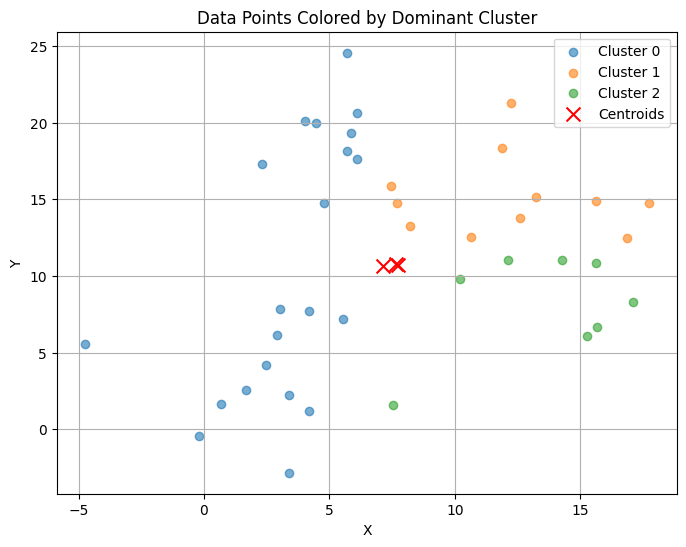

Normalized Mutual Information (NMI): 0.44921131939830194


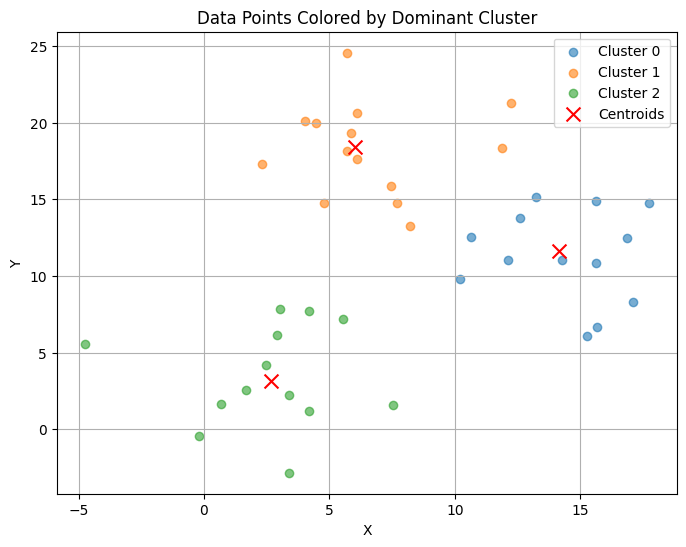

Normalized Mutual Information (NMI): 1.0


In [37]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import normalized_mutual_info_score



num_clusters=3
num_samples = 40

# Generate synthetic data with clusters
X, y = make_blobs(n_samples=num_samples, centers=num_clusters, cluster_std=3, random_state=42)
X += 10



# Visualize the generated data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=20)
plt.title('Synthetic Data for Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


centroids ,membership_mat = fuzzy_cmeans(data=X, num_clusters=num_clusters, max_iter=20, epsilon=.01, m=1.01)

max_membership_cluster = np.argmax(membership_mat, axis=0)
# Plot data points with colors based on their corresponding centroids
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    cluster_data = X[max_membership_cluster == i]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {i}', alpha=0.6)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title('Data Points Colored by Dominant Cluster')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()
# Assuming 'y' contains the true cluster labels and 'max_membership_cluster' contains the cluster labels assigned by your fuzzy clustering algorithm
nmi = normalized_mutual_info_score(y, max_membership_cluster)
print("Normalized Mutual Information (NMI):", nmi)